In [1]:
import os

import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

from utils import utils, warp, image_utils, constant_var
from models import end_2_end_optimization
from options import fake_options
from utils.warp import get_four_corners
import cv2
import plotly.express as px



# if want to run on CPU, please make it False
constant_var.USE_CUDA = False
utils.fix_randomness()

# if GPU is RTX 20XX, please disable cudnn
torch.backends.cudnn.enabled = False




# set some options
opt = fake_options.FakeOptions()
opt.batch_size = 1
opt.coord_conv_template = True
opt.error_model = 'loss_surface'
opt.error_target = 'iou_whole'
opt.goal_image_path = './example.png'
opt.guess_model = 'init_guess'
opt.homo_param_method = 'deep_homography'
opt.load_weights_error_model = 'pretrained_loss_surface'
opt.load_weights_upstream = 'pretrained_init_guess'
opt.lr_optim = 1e-5
opt.need_single_image_normalization = True
opt.need_spectral_norm_error_model = True
opt.need_spectral_norm_upstream = False
opt.optim_criterion = 'l1loss'
opt.optim_iters = 10
opt.optim_method = 'stn'
opt.optim_type = 'adam'
opt.out_dir = './out'
opt.prevent_neg = 'sigmoid'
opt.template_path = './data/template.png'
opt.warp_dim = 8
opt.warp_type = 'homography'




# read original image
goal_image = imageio.imread(opt.goal_image_path, pilmode='RGB')
plt.imshow(goal_image)
plt.show()
print(goal_image.shape)
# resize image to square shape, 256 * 256, and squash to [0, 1]
pil_image = Image.fromarray(np.uint8(goal_image))
pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
goal_image = np.array(pil_image)
plt.imshow(goal_image)
plt.show()
# covert np image to torch image, and do normalization
goal_image = utils.np_img_to_torch_img(goal_image)
if opt.need_single_image_normalization:
    goal_image = image_utils.normalize_single_image(goal_image)
print('mean of goal image: {0}'.format(goal_image.mean()))
print('std of goal image: {0}'.format(goal_image.std()))


ModuleNotFoundError: No module named 'lines_and_field_detection'

/tmp/ipykernel_5981/3971877307.py:2: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.




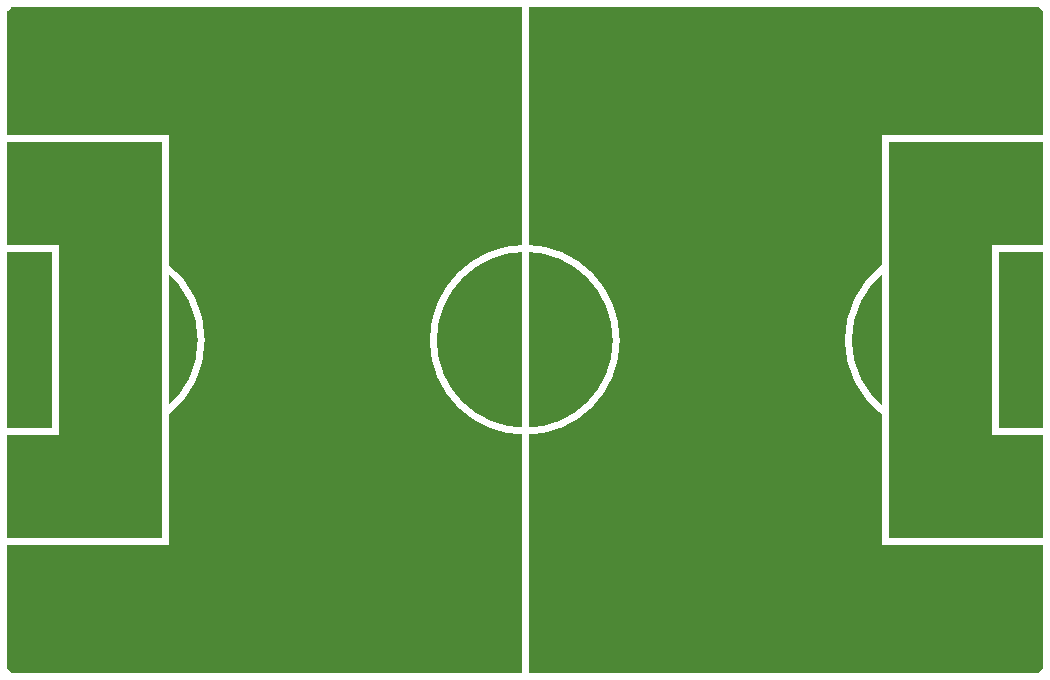

In [37]:
config = dict({'scrollZoom': True})
template = imageio.imread(opt.template_path, pilmode='RGB')
fig = px.imshow(template)
fig.show(config=config)

/tmp/ipykernel_5981/3676582242.py:2: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



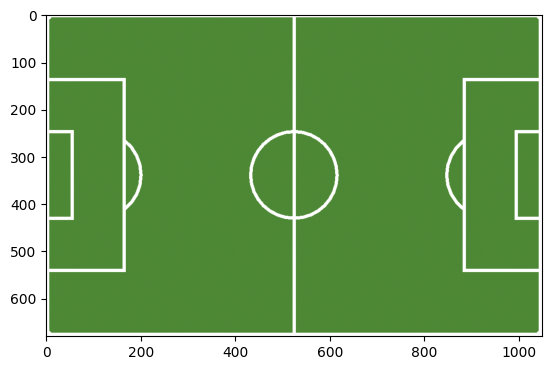

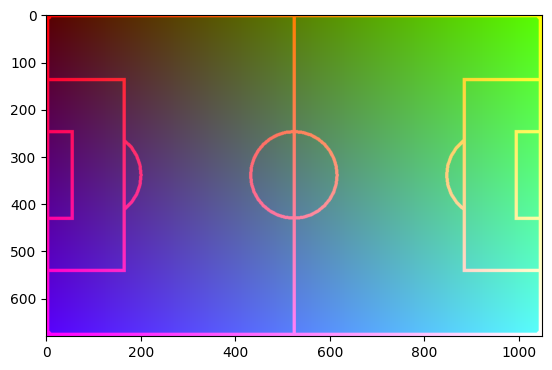

(680, 1050, 3)
mean of template: -9.847688886566175e-08
std of template: 0.9999995231628418


In [3]:
# read template image
template_image = imageio.imread(opt.template_path, pilmode='RGB')
template_image = template_image / 255.0
plt.imshow(template_image)
plt.show()
if opt.coord_conv_template:
    template_image = image_utils.rgb_template_to_coord_conv_template(template_image)
plt.imshow(template_image)
plt.show()
# covert np image to torch image, and do normalization
template_image = utils.np_img_to_torch_img(template_image)
if opt.need_single_image_normalization:
    template_image = image_utils.normalize_single_image(template_image)
print(template.shape)
print('mean of template: {0}'.format(template_image.mean()))
print('std of template: {0}'.format(template_image.std()))

In [8]:
e2e = end_2_end_optimization.End2EndOptimFactory.get_end_2_end_optimization_model(opt)
orig_homography, optim_homography = e2e.optim(goal_image[None], template_image)


---------------------- NOTIFICATION ----------------------

Resnet backbone config for loss_surface
Spectral norm for resnet: True
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for loss_surface
From: ./out/pretrained_loss_surface/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for init_g

  0%|          | 0/10 [00:00<?, ?it/s]/home/skocznapanda/programming/BSc-soccer-annotator/venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)

/home/skocznapanda/programming/BSc-soccer-annotator/venv/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.

100%|██████████| 10/10 [01:31<00:00,  9.16s/it]


/tmp/ipykernel_5981/2982537584.py:3: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

/tmp/ipykernel_5981/2982537584.py:9: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



(720, 1280)


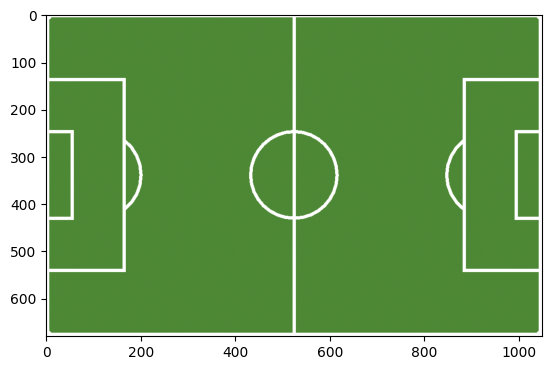

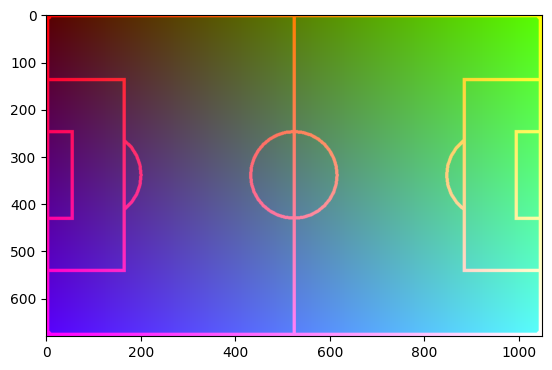


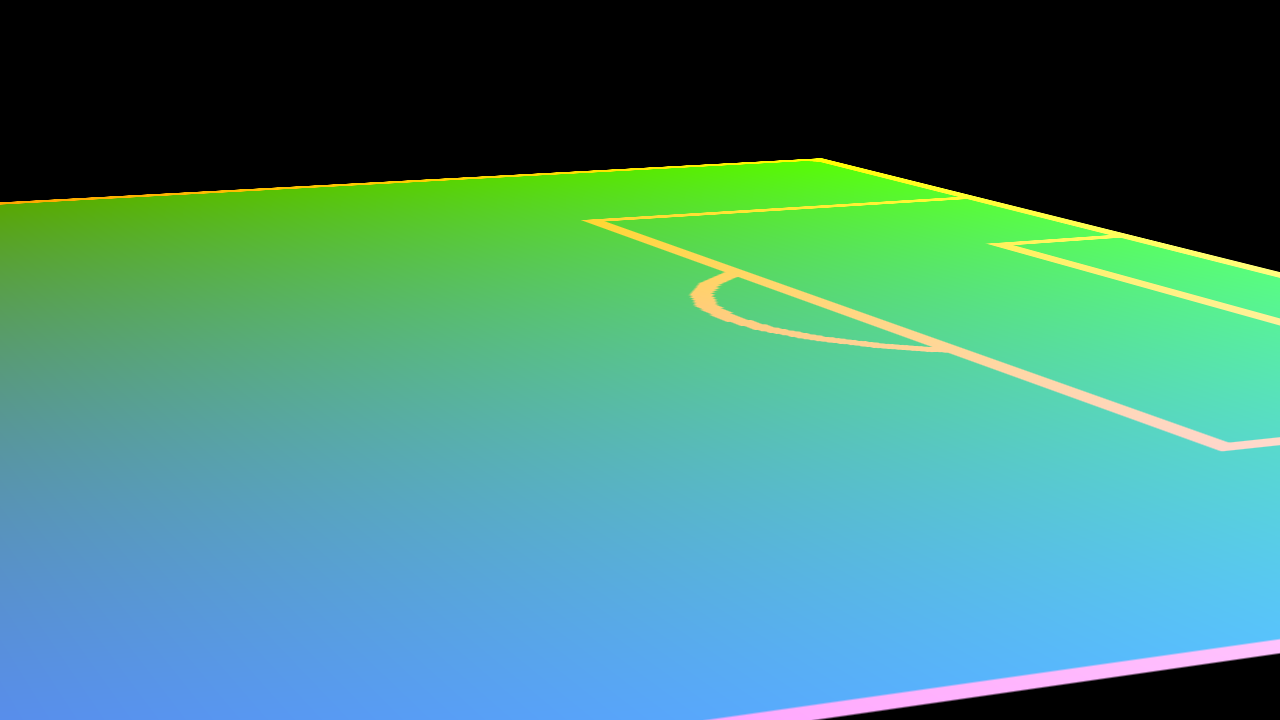

In [9]:
# reload image and template for visualization
# overload goal image
goal_image_draw = imageio.imread(opt.goal_image_path, pilmode='RGB')
goal_image_draw = goal_image_draw / 255.0

outshape = goal_image_draw.shape[0:2]
print(outshape)
# overload template image
template_image_draw = imageio.imread(opt.template_path, pilmode='RGB')
template_image_draw = template_image_draw / 255.0
#special
#template_image_draw[:,:,:] = 0
#template_image_draw[0,:,:] = 1
#print(template_image_draw.shape)
plt.imshow(template_image_draw)
plt.show()
template_image_draw = image_utils.rgb_template_to_coord_conv_template(template_image_draw)
plt.imshow(template_image_draw)
plt.show()
template_image_draw = utils.np_img_to_torch_img(template_image_draw)

# warp template image with initial guess
warped_tmp_orig = warp.warp_image(template_image_draw, orig_homography, out_shape=outshape)[0]
warped_tmp_orig = utils.torch_img_to_np_img(warped_tmp_orig)
fig = px.imshow(warped_tmp_orig)
fig.show()

# warp template image with optimized guess
#warped_tmp_optim = warp.warp_image(template_image_draw, optim_homography, out_shape=outshape)[0]
#warped_tmp_optim = utils.torch_img_to_np_img(warped_tmp_optim)
#plt.imshow(warped_tmp_optim)
#plt.show()


In [22]:
template_image_draw = imageio.imread(opt.template_path, pilmode='RGB')
template_image_draw = template_image_draw / 255.0
template_image_draw = image_utils.rgb_template_to_coord_conv_template(template_image_draw)
template_image_draw = utils.np_img_to_torch_img(template_image_draw)

img, H, out_shape, input_grid = template_image_draw, orig_homography, outshape, None
if out_shape is None:
    out_shape = img.shape[-2:]
if len(img.shape) < 4:
    img = img[None]
if len(H.shape) < 3:
    H = H[None]
assert img.shape[0] == H.shape[0], 'batch size of images do not match the batch size of homographies'


#img[:,:,:,:] = 0
#img[:,:,50:55,500:550] = 1

batchsize = img.shape[0] # 1 image
# create grid for interpolation (in frame coordinates)
if input_grid is None:
    y, x = torch.meshgrid([
        torch.linspace(-utils.BASE_RANGE, utils.BASE_RANGE,
                       steps=out_shape[-2]),
        torch.linspace(-utils.BASE_RANGE, utils.BASE_RANGE,
                       steps=out_shape[-1])
    ])

    x = x.to(img.device)
    y = y.to(img.device)
else:
    x, y = input_grid
x, y = x.flatten(), y.flatten()
# append ones for homogeneous coordinates
xy = torch.stack([x, y, torch.ones_like(x)])
xy = xy.repeat([batchsize, 1, 1])  # shape: (B, 3, N)

# warp points to model coordinates
xy_warped = torch.matmul(H, xy)  # H.bmm(xy)
xy_warped, z_warped = xy_warped.split(2, dim=1)


# we multiply by 2, since our homographies map to
# coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
x_warped, y_warped = torch.unbind(xy_warped, dim=1)


# build grid
grid = torch.stack([
    x_warped.view(batchsize, *out_shape[-2:]),
    y_warped.view(batchsize, *out_shape[-2:])
],
    dim=-1)

print(grid[0,-1,0,:])
print
"""
img[:,:,0,:] = 255
# sample warped image
warped_img = torch.nn.functional.grid_sample(
    img, grid, mode='bilinear', padding_mode='zeros')

if utils.hasnan(warped_img):
    print('nan value in warped image! set to zeros')
    warped_img[utils.isnan(warped_img)] = 0

warped_img = warped_img[0]
warped_img = utils.torch_img_to_np_img(warped_img)
print(warped_img.sum())
fig = px.imshow(warped_img)
fig.show()
"""

tensor([0.1150, 0.8447], grad_fn=<SliceBackward0>)


/tmp/ipykernel_5981/1392119268.py:1: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



"\nimg[:,:,0,:] = 255\n# sample warped image\nwarped_img = torch.nn.functional.grid_sample(\n    img, grid, mode='bilinear', padding_mode='zeros')\n\nif utils.hasnan(warped_img):\n    print('nan value in warped image! set to zeros')\n    warped_img[utils.isnan(warped_img)] = 0\n\nwarped_img = warped_img[0]\nwarped_img = utils.torch_img_to_np_img(warped_img)\nprint(warped_img.sum())\nfig = px.imshow(warped_img)\nfig.show()\n"

In [36]:
result = orig_homography.matmul(torch.tensor([-.5, .5, 1]))

xy, z = result.split(2, dim=1)
xy = 2 * xy / z
x = xy[0,0]
y = xy[0,1]
x = (x + 1) * (720 / 2),
y = (y + 1) * (1280 / 2)
x, y

((tensor(401.3928, grad_fn=<MulBackward0>),),
 tensor(1180.6052, grad_fn=<MulBackward0>))

In [19]:
def find_closest_point(x, y, input_grid):

    input_grid = input_grid.detach().numpy()[0]
    input_grid[np.abs(input_grid[:,:,0]) >= 1] = np.inf
    input_grid[np.abs(input_grid[:,:,1]) >= 1] = np.inf

    input_grid[:,:,0] -= x
    input_grid[:,:,1] -= y
    return np.abs(input_grid[:,:,0]) + np.abs(input_grid[:,:,1])

In [20]:
closest = find_closest_point(1,-1,grid)
#fi = np.where(closest == closest.min())
#fi.shape
np.where(closest == closest.min())

(array([158]), array([822]))

(array([719]), array([0]))

In [181]:
closest.min()

0.0065622795